In [6]:
import sys

sys.path.append('../')

import os
import glob
from operator import attrgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.manifold import TSNE

from transformers import AutoModelForCausalLM, AutoTokenizer

from hypernet import TaskWeaver
from dsconf import DatasetConfig

from typing import List, Optional

from dotenv import load_dotenv

load_dotenv('../../.env')

sns.set_style('darkgrid')

In [2]:
models = ['EleutherAI/pythia-70m', 'google/gemma-3-270m-it', 'Qwen/Qwen3-0.6B']

lora_path_templates = {
    'EleutherAI/pythia-70m': "gpt_neox.layers.{layer}.attention.{module}.{matrix}",
    'google/gemma-3-270m-it': "model.layers.{layer}.self_attn.{module}.{matrix}",
    'Qwen/Qwen3-0.6B': "model.layers.{layer}.self_attn.{module}.{matrix}"
}

modules = {
    'EleutherAI/pythia-70m': ["query_key_value"],
    'google/gemma-3-270m-it': ["q_proj", "v_proj"],
    'Qwen/Qwen3-0.6B': ["q_proj", "v_proj"]
}

dataset_names = {
    'allenai/ai2_arc.ARC-Challenge': 'ARC Challenge',
    'allenai/ai2_arc.ARC-Easy': 'ARC Easy',
    'allenai/openbookqa.main': 'OpenBookQA',
    'allenai/winogrande.winogrande_m': 'Winogrande (M)',
    'ChilleD/SVAMP': 'SVAMP',
    'ehovy/race.middle': 'RACE (Middle)',
    'google/boolq': 'BoolQ',
    'openai/gsm8k.main': "GMS8K",
    'Rowan/hellaswag': "HELLASWAG",
    'stanfordnlp/snli': "SNLI",
    "tau/commonsense_qa": "CommonSenseQA",
    "mix_8": "Mixed Dataset"
}


## Basline LoRA

T-SNE between individual LoRA adapaterrs and Mixed LoRA adapter

In [3]:
def get_weight_tensor(model: AutoModelForCausalLM, lora_path_template: str, modules: List[str], layers: Optional[List[int]] = None, matrices: List[str] = ['lora_A', 'lora_B']):
    
    tensors = []
    layers = range(model.config.num_hidden_layers) if layers is None else layers
    for layer in layers:
        for module in modules:
            for matrix in matrices:
                getter = attrgetter(lora_path_template.format(layer=layer, module=module, matrix=matrix))
                matrix = getter(model).default.weight.data
                tensors.append(matrix.flatten())

    return torch.cat(tensors).numpy()

In [4]:
X = {}
y = {}

for model_name in models:
    lora_dirs = glob.glob(os.path.join('../_models/lora', model_name.replace('/', '_'), '*'))

    X[model_name], y[model_name] = [], []
    for lora_path in lora_dirs:
        dataset = lora_path.split('/')[-1]
        model = AutoModelForCausalLM.from_pretrained(lora_path, device_map='cpu')
        X[model_name].append(get_weight_tensor(model, lora_path_templates[model_name], modules=modules[model_name]))
        try:
            y[model_name].append(dataset_names[dataset.replace('_', '/', 1)])
        except KeyError:
            y[model_name].append(dataset_names[dataset])
    

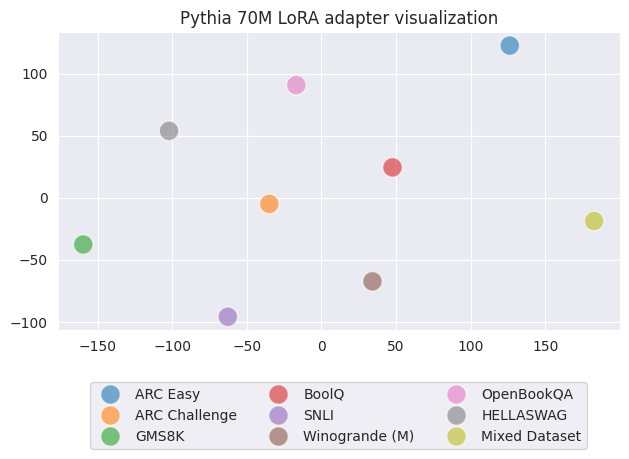

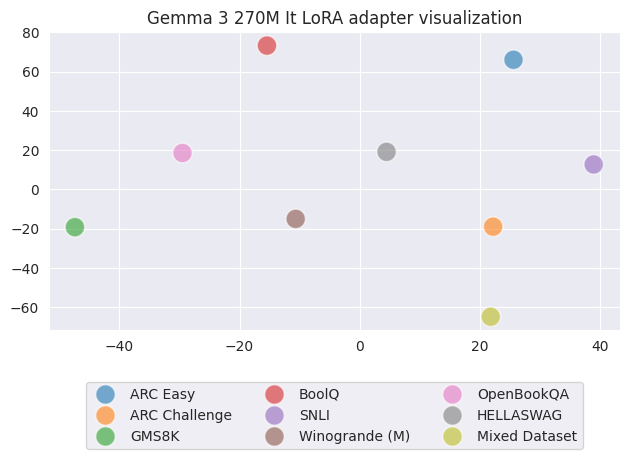

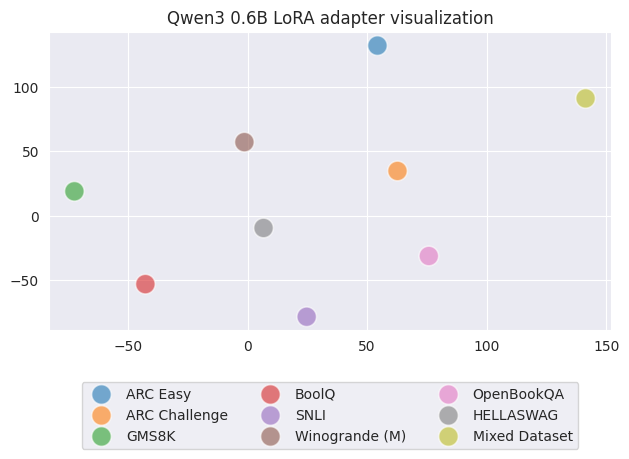

In [5]:
for model_name in models:
    tsne = TSNE(n_components=2, random_state=42, perplexity=6)
    X_embed = tsne.fit_transform(np.vstack(X[model_name]))

    # Create DataFrame for seaborn
    df = pd.DataFrame({
        'x': X_embed[:, 0],
        'y': X_embed[:, 1],
        'dataset': y[model_name]
    })

    sns.scatterplot(data=df, x='x', y='y', hue='dataset', palette='tab10', alpha=0.6, s=200)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'{model_name.split('/')[1].replace('-', ' ').title()} LoRA adapter visualization')
    plt.tight_layout()
    plt.show()

## Generated LoRA adapter analysis

In [7]:
hypernets = {}
tokenizers = {}

for model_name in models:
    model_path = f'../_models/hypernet/{model_name.replace("/", "_")}/mix_8_d1024_r2_a8'
    hypernets[model_name] = TaskWeaver.from_pretrained(model_path, device='cpu')
    tokenizers[model_name] = AutoTokenizer.from_pretrained(model_name)
    if tokenizers[model_name].pad_token is None:
        tokenizers[model_name].pad_token = tokenizers[model_name].eos_token

Loading base language model: EleutherAI/pythia-70m
TaskWeaver hypernetwork loaded from ../_models/hypernet/EleutherAI_pythia-70m/mix_8_d1024_r2_a8
Loading base language model: google/gemma-3-270m-it
TaskWeaver hypernetwork loaded from ../_models/hypernet/google_gemma-3-270m-it/mix_8_d1024_r2_a8
Loading base language model: Qwen/Qwen3-0.6B
TaskWeaver hypernetwork loaded from ../_models/hypernet/Qwen_Qwen3-0.6B/mix_8_d1024_r2_a8


In [8]:
weights = {model_name: {} for model_name in models}

for model_name in models:
    model = hypernets[model_name]
    tokenizer = tokenizers[model_name]
    
    for dataset_id in DatasetConfig.list_available(return_ids=True):
        config = DatasetConfig.from_dataset_id(dataset_id)
        dataset = config.load_and_process(False).shuffle(42)[:10]

        weights_list = []
        for sample in dataset['prompt']:
            inputs = tokenizer(sample, return_tensors='pt', truncation=True, max_length=512)
            lora_weights = model._hypernet_forward(inputs['input_ids'], inputs['attention_mask'])
            
            tensors = []
            for layer_dict in lora_weights:
                for module_name, matrix_dict in layer_dict.items():
                    for matrix_name, tensor in matrix_dict.items():
                        tensors.append(tensor.detach().flatten())
            
            weights_list.append(torch.cat(tensors).numpy())
        weights[model_name][dataset_id] = weights_list

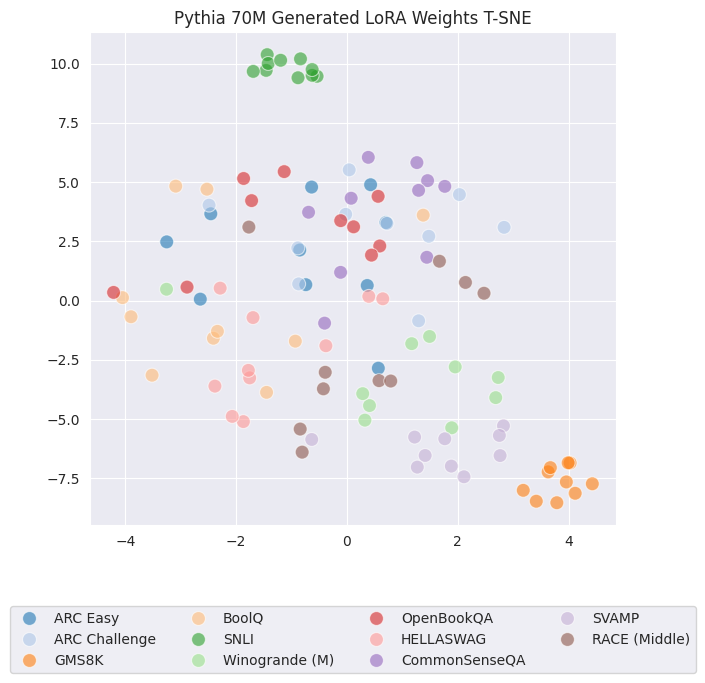

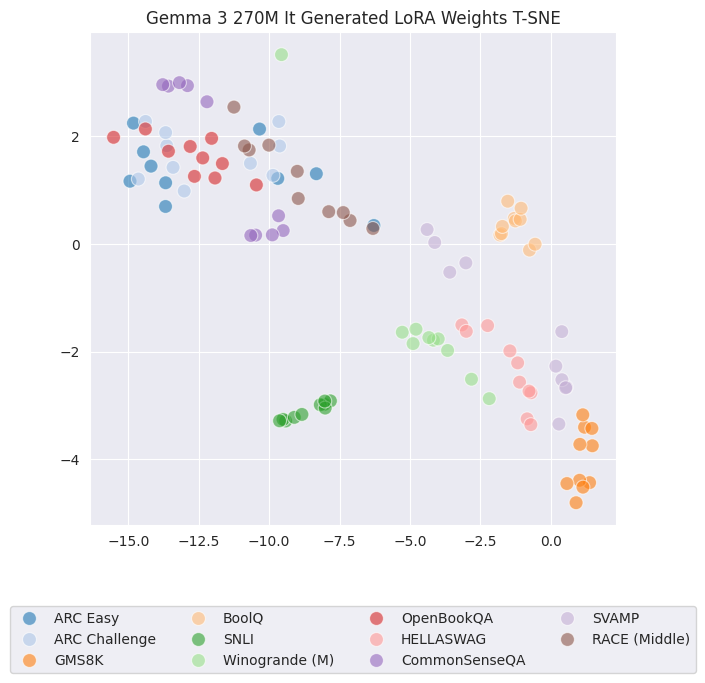

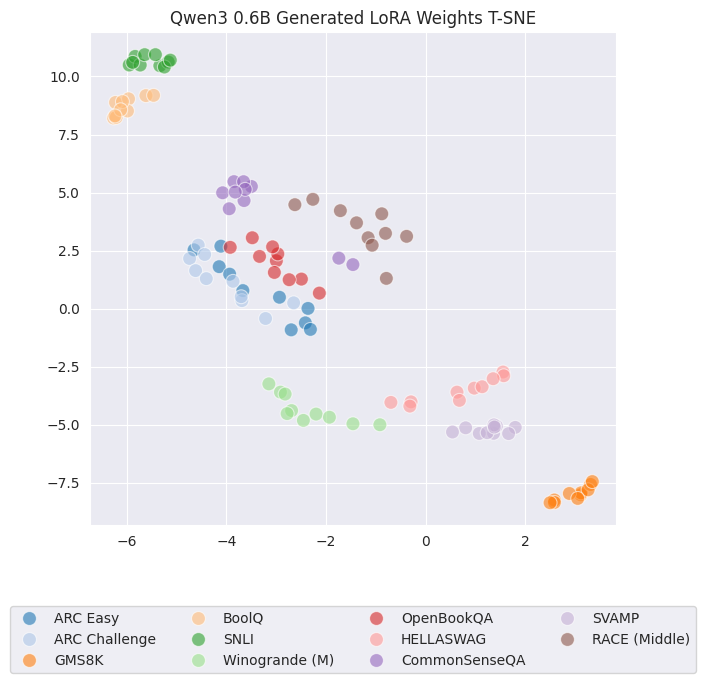

In [13]:
for model_name in models:
    # Flatten all weights and create labels
    all_weights = []
    all_labels = []
    for dataset_id, weight_list in weights[model_name].items():
        for w in weight_list:
            all_weights.append(w)
            all_labels.append(dataset_names[dataset_id])

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_weights) - 1))
    weights_embed = tsne.fit_transform(np.vstack(all_weights))

    # Create DataFrame for seaborn
    df = pd.DataFrame({
        'x': weights_embed[:, 0],
        'y': weights_embed[:, 1],
        'dataset': all_labels
    })

    # Plot with seaborn
    plt.figure(figsize=(7, 7))
    sns.scatterplot(data=df, x='x', y='y', hue='dataset', palette='tab20', alpha=0.6, s=100)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'{model_name.split('/')[1].replace('-', ' ').title()} Generated LoRA Weights T-SNE')
    plt.tight_layout()
    plt.show()